In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.v2 import ToImage, ToDtype, Normalize, RandomAffine, RandomCrop, RandomHorizontalFlip

from matplotlib import pyplot as plt
import numpy as np
import time
from datetime import datetime 

In [18]:
print(torch.cuda.is_available(), torch.cuda.get_device_name())

True NVIDIA GeForce RTX 4060


In [19]:
train_transforms = transforms.Compose([
    ToImage(), # to torch.Image uint8
    ToDtype(torch.float32, scale=True), # [0, 255] -> [0, 1] & uint8 -> float32
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalize after scale
    RandomAffine(
      degrees=10,
      translate=(0.15, 0.15),
      scale=(0.9, 1.1)
    ),
   RandomCrop(32, padding=4),
   RandomHorizontalFlip()
])

test_transforms = transforms.Compose([
  ToImage(),
  ToDtype(torch.float32, scale=True),
  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [20]:
trainD = datasets.CIFAR100(root="cifar100", train=True, transform=train_transforms, download=True)
testD = datasets.CIFAR100(root="cifar100", train=False, transform=test_transforms, download=True)
# trainD = datasets.CIFAR100(root="cifar100", train=True, download=True)
# testD = datasets.CIFAR100(root="cifar100", train=False, download=True)

In [21]:
# img, label = trainD[np.random.randint(len(trainD))]
# plt.imshow(img)
# testD.classes[label]
# len(testD.classes)

In [22]:
BATCH_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDL = DataLoader(trainD, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
testDL = DataLoader(testD, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

In [23]:
class Cifar(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.Conv2d(3, 64, 3, padding=1), # 32x32x64
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.Conv2d(64, 128, 3), # 29x29x128
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 14x14x128

      nn.Conv2d(128, 256, 3, padding=1), # 14x14x256
      nn.BatchNorm2d(256),
      nn.ReLU(),

      nn.Conv2d(256, 216, 5), # 10x10x216 
      nn.BatchNorm2d(216),
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 5x5x216

      nn.Flatten(),
      nn.Linear(5*5*216, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(),
      nn.Dropout(0.3),

      nn.Linear(512, 100)
    )

  def forward(self, x):
    logits = self.model(x)
    return logits

In [24]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  
  for batch_i, (X, y) in enumerate(dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    # get predictions
    preds = model(X)
    # calculate loss
    loss = loss_fn(preds, y)
    # backprop
    loss.backward()
    # gradient descent 
    optimizer.step()    
    optimizer.zero_grad()

    if (batch_i % 50 < 1) or (batch_i == len(dataloader) - 1):
      print(f"Batch {batch_i+1}/{len(dataloader)}, Loss: {loss.item():.4f}")


def test(dataloader, model, loss_fn):
  model.eval()
  loss_t = correct = 0
  size, num_batches = len(dataloader.dataset), len(dataloader)
  
  # run through testing data
  with torch.no_grad():
    for batch_i, (X, y) in enumerate(dataloader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      # get model preds
      preds = model(X)
      loss_t += loss_fn(preds, y).item()
      correct += (preds.argmax(dim=1) == y).type(torch.float).sum().item()
    
  # calculate average loss & accuracy
  avg_loss = loss_t / num_batches  
  accuracy = correct / size * 100

  print(f"TEST, Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")

  return accuracy, avg_loss
  

def fit(model, epochs: int):
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
  loss_fn = torch.nn.CrossEntropyLoss()

  accuracies, losses = [], []

  start_time = datetime.now()

  print("Starting...")
  for epoch in range(epochs):
    print("\nEpoch", epoch+1)

    train(trainDL, model, loss_fn, optimizer)
    acc, loss = test(testDL, model, loss_fn )

    accuracies.append(acc)
    losses.append(loss)

  torch.save(model.state_dict(), "cifar100_weights.pth")
  print("\nDone!\nWeights saved to 'cifar100_weights.pth'")
  print(f"Peak Accuracy: {max(accuracies):.2f}% @ Epoch {accuracies.index(max(accuracies))+1}")
  print(f"Time spent training: {(datetime.now() - start_time).total_seconds():.2f}s")
  return accuracies, losses


In [26]:
EPOCHS = 50
model = Cifar().to(DEVICE)

acc, loss = fit(model, EPOCHS)


Starting...

Epoch 1


Batch 1/196, Loss: 4.7539
Batch 51/196, Loss: 3.8771
Batch 101/196, Loss: 3.6788
Batch 151/196, Loss: 3.5374
Batch 196/196, Loss: 3.2216
TEST, Accuracy: 23.54%, Loss: 3.1940

Epoch 2
Batch 1/196, Loss: 3.4104
Batch 51/196, Loss: 3.1429
Batch 101/196, Loss: 3.0972
Batch 151/196, Loss: 3.0812
Batch 196/196, Loss: 2.9934
TEST, Accuracy: 33.02%, Loss: 2.6551

Epoch 3
Batch 1/196, Loss: 2.8247
Batch 51/196, Loss: 2.7945
Batch 101/196, Loss: 2.7930
Batch 151/196, Loss: 2.6085
Batch 196/196, Loss: 2.9953
TEST, Accuracy: 36.55%, Loss: 2.4658

Epoch 4
Batch 1/196, Loss: 2.6832
Batch 51/196, Loss: 2.6597
Batch 101/196, Loss: 2.5687
Batch 151/196, Loss: 2.5375
Batch 196/196, Loss: 2.5937
TEST, Accuracy: 41.50%, Loss: 2.2168

Epoch 5
Batch 1/196, Loss: 2.4886
Batch 51/196, Loss: 2.4070
Batch 101/196, Loss: 2.1881
Batch 151/196, Loss: 2.2541
Batch 196/196, Loss: 2.7773
TEST, Accuracy: 45.06%, Loss: 2.0613

Epoch 6
Batch 1/196, Loss: 2.4433
Batch 51/196, Loss: 2.3183
Batch 101/196, Loss: 2.2063
Batc

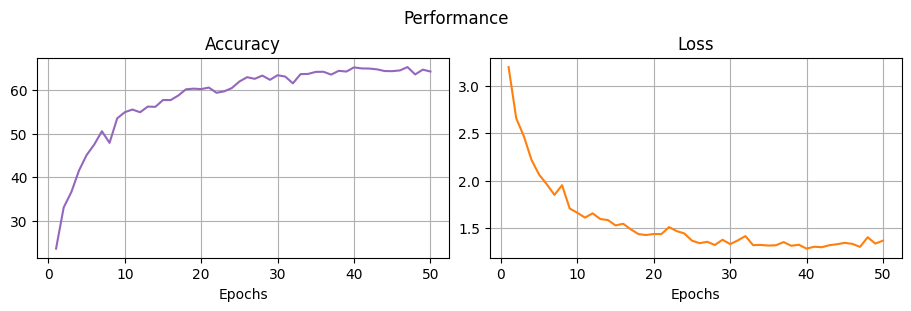

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 3), layout="constrained")
fig.suptitle("Performance")

epochs = range(1, EPOCHS+1)

ax1, ax2 = axs[0], axs[1]

ax1.plot(epochs, acc, "tab:purple")
ax1.set_title("Accuracy")
ax1.set_xlabel("Epochs")
ax1.grid(True)

ax2.plot(epochs, loss, "tab:orange")
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")
ax2.grid(True)

plt.savefig(f"performance_{int(time.time())}")

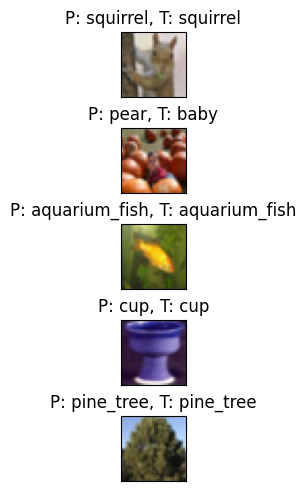

In [29]:
def predict(model):
  model.eval()
  fig, axs = plt.subplots(5, 1, layout="constrained")

  for i in range(5):
    X, label = testD[np.random.randint(len(testD))] # tensor image, label
    
    unnorm = Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])
    img = unnorm(X)
    axs[i].imshow(img.permute(1, 2, 0))

    X = X.unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
      pred = model(X).argmax(dim=1).item()
    axs[i].set_title(f"P: {testD.classes[pred]}, T: {testD.classes[label]}") 
    axs[i].yaxis.set_visible(False)
    axs[i].xaxis.set_visible(False)
  
  plt.show()
  

predict(model)
